#### The Trouble with Response Times

Recently, I wanted to analyse response times from a visual search task. For me the standard approach of feeding measurements with highly skewed distributions and censored values into Anova is not acceptable. Unfortunately, I found little guidance on how to conduct a Gelman style analysis (Gelman & Shalizie, 2013). There are no instances of say Gamma regression or Weibull regression in BDA or in Gelman & Hill (2007). I took a look at the Bayesian Survival Analysis by Ibrahim, Chen & Sinha (2005). This book treats the relevant models. It presents an overview of the literature, but gives little guidance on how to select an appropriate model. Besides Survival Times are not exactly response times and the lessons from survival analysis may not be applicable here. 

I did a little research on the Internet and in the psychological literature. I thought it may be useful to share what I learned. This is the first post in series. It gives an overview of the most popular models and the theory and motivation behind them.

In [1]:
%pylab inline
from scipy import stats
np.random.seed(3)
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
from urllib import urlopen
Image(url='http://tiny.cc/tpiaox')

Populating the interactive namespace from numpy and matplotlib


Two distributions with positive and negative skew are shown above. They occur frequently in psychological research. The prime example are response times or solution times with positive skew. These arise in experiments where subject hits a key and terminates the trial as soon as he makes a decision. As an example consider the distribution of reaction times from four subjects from one of my studies. The subject was asked to hit a key as soon as he detected a pair of chasing rings among twelve other randomly moving distractors. 

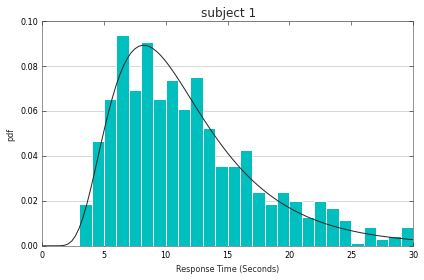

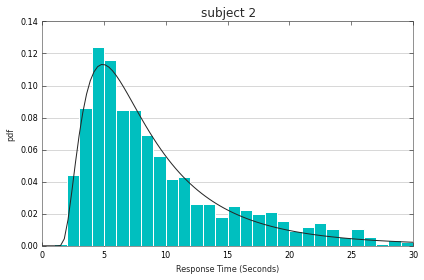

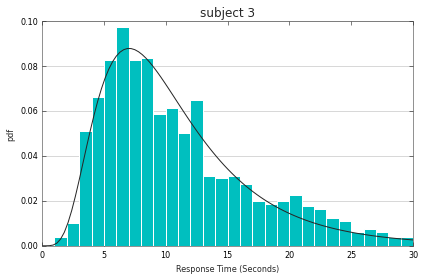

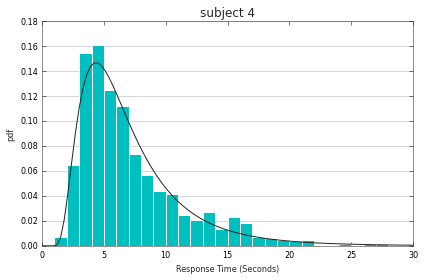

In [2]:
for d in range(1,5):
    plt.figure()
    f=urlopen('http://tiny.cc/iriaox'%d)
    D=np.loadtxt(f)
    y=D[D[:,3]<35,6]
    y=y[y<30]
    x=np.linspace(0,30,31)
    plt.hist(y,bins=x,normed=True,color='c',edgecolor='w');
    plt.grid(b=False,axis='x')
    mlest=stats.lognorm.fit(y)
    x=np.linspace(0,30,101)
    plt.plot(x,stats.lognorm.pdf(x,mlest[0],mlest[1],mlest[2]));
    plt.xlabel('Response Time (Seconds)')
    plt.ylabel('pdf');
    plt.title('subject %d'%d)

The distributions for fours subjects displayed above are similar in some aspects but vary in other aspects. We are looking for a simple model which would capture the diversity and complexity of the data. The black curve shows one such proposal.

Notable feature of these distributions is that response times can only have positive values. This provides a constraint on the shape of the distribution. You can envision a normal distribution which is pushed against the vertical line at $x=0$. However as the probability mass hits the wall it pushed back and acumulates on the positive side. Or we can just cut away the negative values. The result looks like this?

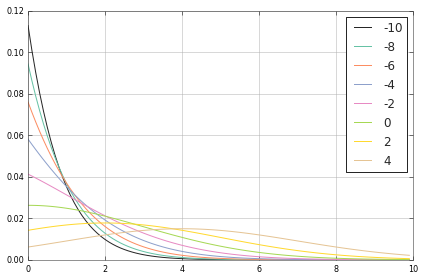

In [3]:
ms= range(-10,5,2)
for m in ms:
    x=np.arange(0,10,0.1)
    y=stats.norm.pdf(x,m,3)
    y/=y.sum()
    plt.plot(x,y)
plt.legend(ms);

This is a naive approach. The truncated gaussian makes a sharp jump at $x=0$. In the distribution from our subjects we do not see such a jump. The solution times peak around 6-7 seconds and the distribtion goes towards $p(x=0)=0$ in continuous fashion. To obtain better candidates we now explore processes that give rise to skewed distributions in a systematic way.

#### Geometric distribution

We start really simple with a discrete distribution. Subject makes a decision at discrete time steps $t=1,2,3,\dots$. At each step the subject solves the task with probability $\beta$. What is the probability that he solves the task at step $\tau$? It is the product of the probabilities at each decision step. The subject has solved the task at step $t$ (with probability $\beta$) and failed to solve the task at all previous steps (with probability $1-\beta$ at each step). Hence $p(t=\tau)=\beta (1-\beta)^{\tau-1}$. This distribution is called geometric. It looks like this

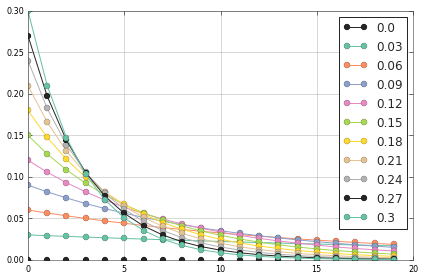

In [4]:
ms= np.linspace(0,0.3,11)
for m in ms:
    x=np.arange(0,20)
    y=m*np.power(1-m,x)
    plt.plot(x,y,'o-')
plt.legend(ms);

#### Exponential distribution

There are two features that we don't like about the geometric distribution. First the distribution always peeks at $x=0$. We would like to obtain distributions that have mode somewhere $x>0$. Second, the measured reaction times are continuous. Let's get rid of the second problem,first. We derive the continuous analogue of geometric distribution. With no discrete steps we need to think about $\alpha$ as a rate. $\alpha$ then gives the number of decisions per a unit of time. If $\beta=0.8$ per second then $\beta=0.4$ per half of a second and $\beta=60\cdot 0.8 = 48$ per minute. 

Now consider a case of geometric distribution with $t=6$ and $\beta=0.2$. Then $p(t=6)=0.2 \cdot (0.8)^{5}= 0.655$. We have 5 time steps at which no decision was made. We split each of them into halves. We now have ten time steps where no decision was made. Each time step now has length 0.5 and probability of no decision at each of these steps is $0.8/2=0.4$. Such modification doesn't change $t=0.5\cdot 10 = 1 \cdot5$. However it alters $p(t=6)=0.2 \cdot (0.4)^{10}= 0.0001$. (Why do we choose $0.8/2=0.4$ instead of $\sqrt{0.8}=0.89$? This is because we want to hold the number of non-decision events constant at 5 irrespective of the number of bins. With $0.4$ we distribute 5 non-decisions across 10 bins. With $\sqrt{0.8}$ we would distribute 10 non-decisions across 10 bins.) We can generalize the process of division. The probability of no decision per reduced bin is $\frac{\tau (1-\beta)}{n}$, where $n$ is the number of bins. Then the probability of $\tau$ steps over the reduced bins  is

$\beta \left(\frac{\tau (1-\beta)}{n}\right)^{n}$

We obtain the exponential distribution by making the bins infinitely small. 

$$\lim_{n \to \infty} \beta \left(\frac{\tau (1-\beta)}{n}\right)^{n} =\beta e^{-\beta\tau} $$

Here is what the exponential pdf looks like for various parameter values.

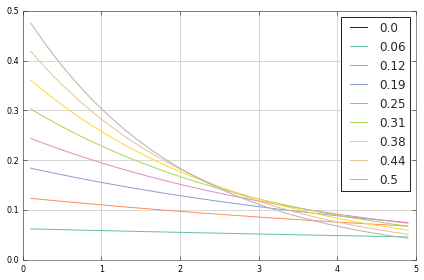

In [5]:
ms= np.linspace(0,0.5,9)
for m in ms:
    x=np.arange(0.1,5,0.1)
    y=m*np.exp(-m*x)
    plt.plot(x,y)
plt.legend(np.round(ms,2));

#### Gamma distribution

Next we would like to obtain distribution that is also capable of curves with mode away from $x=0$. The general strategy for obtaining more flexible distribution is to build a mixture of the simpler ones. In our case we conceive the following process. In order to reach a decision multiple serial stages of the same exponential process need to finish. We draw $\alpha$ samples from an exponential distribution with decision rate $\beta$ and sum them to obtain the total decision time.

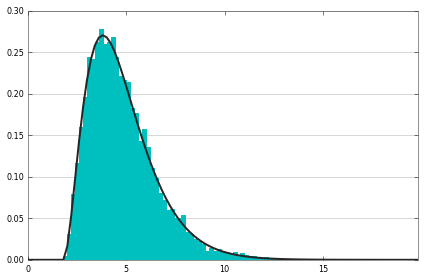

In [6]:
b=1.6;a=3
h=stats.expon.rvs(b,size=[10000,a]).sum(1)-a
x=np.arange(0,20,0.2)
y=stats.erlang.pdf(x-x[1],a,b)
plt.hist(h,bins=x,normed=True,color='c',edgecolor='c');
plt.plot(x,y,lw=2)
plt.xlim([x[0],x[-1]]);
plt.grid(b=False,axis='x')

The resulting distribution is called Erlang distribution. An example of Erlang with $\beta=1.6$ and $\alpha=3$ is depicted above along with the results of a simulation of the underlying multistage proces. 

For our purposes however Gamma distribution will be more useful. Gamma is a cousin of Erlang. The only difference is that the number of bins $\alpha$ is continuous in Gamma while it is discrete in Erlang. 

Erlang has the following PDF

$$p(t;\beta,\alpha)=\frac{\beta^\alpha}{(\alpha-1)!} t^{\alpha-1} e^{-\beta t}$$


Gamma distribution has PDF.

$$p(t;\beta,\alpha)=\frac{ \beta^\alpha}{\Gamma(\alpha)} t^{\alpha-1} e^{-\beta t}$$

The last term is the common heritage from their exponential ancestor. The middle term arises from the combinatorics of summing exponentially distributed variables and is the same for both distributions. The distributions differ only in terms of the normalizing constant.

Let's see what Gamma can do. We look how the distribution changes for different parameter values.

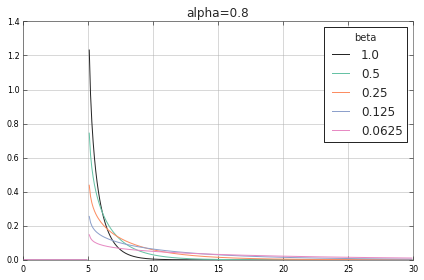

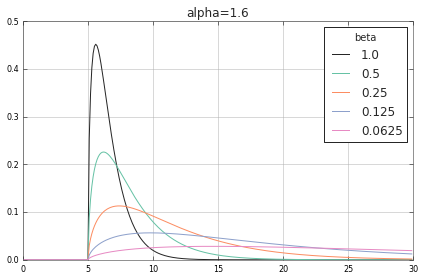

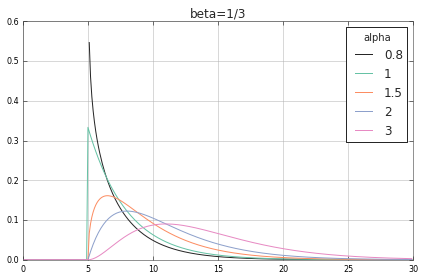

In [7]:
x=np.arange(0,30,0.1)
for h in [0.8,1.6]:
    plt.figure()
    mm=[1,2,4,8,16]
    for m in mm:
        plt.plot(x,stats.gamma.pdf(x,a=h,scale=m, loc=5))
    plt.legend(1/np.array(mm,dtype='float'),title='beta')
    plt.title('alpha=%.1f'%h)
plt.figure()
mm=[0.8,1,1.5,2,3]
for m in mm:
    plt.plot(x,stats.gamma.pdf(x,a=m,scale=3, loc=5))
plt.legend(mm,title='alpha');
plt.title('beta=1/3');

We see curves with mode at $x>0$. These are similar to the reponse times from our human subjects. At the same time with Gamma we can create the exponential-like distributions with mode at $x=0$. Although not present in the data for our for subjects, these also do occur in psychological research, for instance in fast detection tasks.

#### Weibull Distribution

Gamma distribution is already fine for the purpose of our data set. However, there are further options which can make difference with other datasets.  Let's look at these.

To do so let's go one step back to the exponential distribution and ask if there is another way to extend it. We chose rate $\beta$ that evolves exponentially the response time. The PDF of Weibull distribution is given by

$$\alpha\beta\left(\beta t\right)^{\alpha-1}e^{-(\beta t)^{\alpha}}$$

Parameter $\alpha$ is the new stuff. $\alpha$ is a positive real parameter. The  term $(\beta t)^{\alpha}$ is crucial here. If $\alpha>1$ then this term explodes and Weibull loses its tail and the positive skew. On the other hand if $\alpha<1$ then the term increases only slowly and Weibull has a fat tail. (If $\alpha=1$ we obtain exponential distribution.)

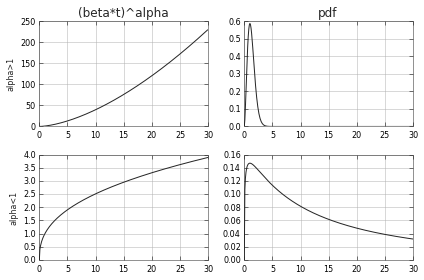

In [8]:
for i in range(2):
    a=[1.6,0.4][i]
    plt.subplot(2,2,i*2+1)
    if i==0: plt.title('(beta*t)^alpha');plt.ylabel('alpha>1')
    else: plt.ylabel('alpha<1')
    x=np.arange(0,30,0.1)
    plt.plot(x,np.power(x,a))
    plt.subplot(2,2,i*2+2)
    if i==0: plt.title('pdf')
    plt.plot(x,a*np.power(x,a)*np.exp(-np.power(x,a)))

We now do gymnastics. The graphs show that by proper choice of $\alpha$ we can obtain a distribution that is almost symmetric. This is something that Gamma can't do. 

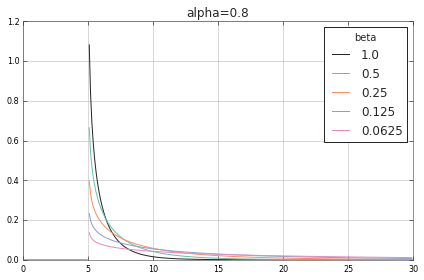

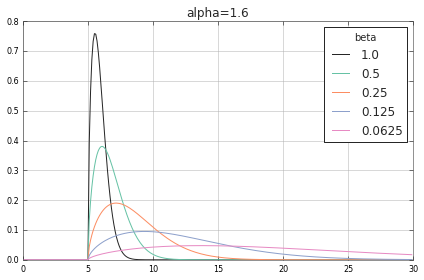

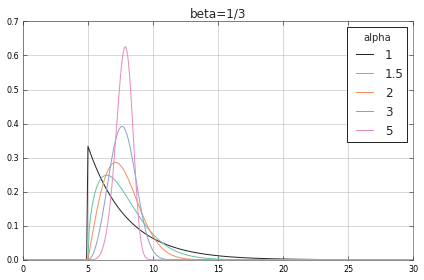

In [9]:
x=np.arange(0,30,0.1)
for h in [0.8,1.6]:
    plt.figure()
    mm=[1,2,4,8,16]
    for m in mm:
        plt.plot(x,stats.weibull_min.pdf(x,h,scale=m, loc=5))
    plt.legend(1/np.array(mm,dtype='float'),title='beta');
    plt.title('alpha=%.1f'%h);
plt.figure()
mm=[1,1.5,2,3,5]
for m in mm:
    plt.plot(x,stats.weibull_min.pdf(x,m,scale=3, loc=5))
plt.legend(mm,title='alpha');
plt.title('beta=1/3');

#### ExGaussian Distribution

We now go back to the exponential distribution and explicitly start with the goal of obtaining a distribution that covers the skew range between the exponential distribution and the normal distribution. The most straightforward way to do this is to build a mixture of two variables $Z=X+Y$ where $X \sim \mathcal{N}(\mu,\sigma)$ and $Y \sim \mathrm{Expon}(\beta)$. Then $Z \sim \mathrm{ExGauss}(\mu,\sigma,\beta)$. It's PDF is given by
$$f(x;\mu,\sigma,\beta) = \frac{\beta}{2} \exp\left(\frac{\beta}{2} \left(2 \mu + \beta \sigma^2 - 2 x\right)\right)
             \operatorname{erfc} \left(\frac{\mu + \beta \sigma^2 - x}{ \sqrt{2} \sigma}\right)$$

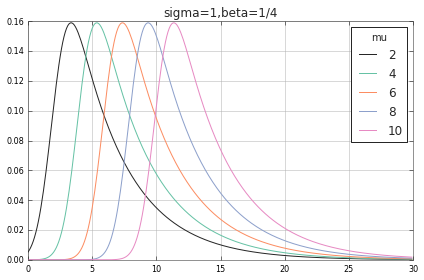

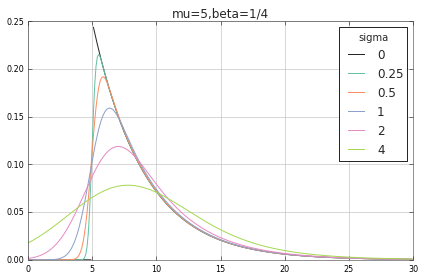

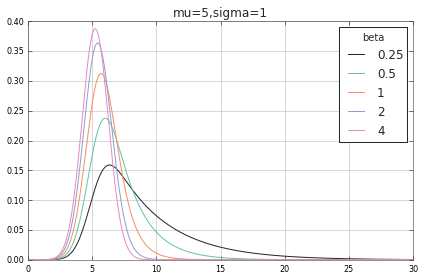

In [10]:
from scipy.special import erf

def exgausspdf(x,mu=0,sigma=1,beta=1):
    ''' mu - mean of gaussain
        sigma - sd of gaussian
        beta - rate of the exponential distribution
    '''
    a=(1-erf((mu+beta*np.square(sigma)-x)/(np.sqrt(2)*sigma)))
    return beta/2.*np.exp(beta*(2*mu+beta*np.square(sigma)-2*x)/2.)*a

x=np.arange(0,30,0.1)
plt.figure()
mm=[2,4,6,8,10]
for m in mm:
   plt.plot(x,exgausspdf(x,mu=m,sigma=1,beta=0.25))
plt.legend(mm,title='mu');
plt.title('sigma=1,beta=1/4');

plt.figure()
mm=[0,0.25,0.5,1,2,4]
for m in mm:
   plt.plot(x,exgausspdf(x,mu=5,sigma=m,beta=0.25))
plt.legend(mm,title='sigma');
plt.title('mu=5,beta=1/4');

plt.figure()
mm=[0.25,0.5,1,2,4]
for m in mm:
   plt.plot(x,exgausspdf(x,mu=5,sigma=1,beta=m))
plt.legend(mm,title='beta');
plt.title('mu=5,sigma=1');

The effect of parameters on the shape of distribution can be intuited from their respective role as parameters of the gaussian and exponential distribution. $\beta$ and $\sigma$ control the respective contribution of the exponential and gaussian component. As $\sigma \to 0$ Exgaussian reduces to shifted exponential. Exgaussian has three parameters which offers more modeling flexibility than the distributions we reviewed so far.

#### Lognormal Distribution

Above we have concentrated on the flexibility afforded the probability distribution of the model. Lognormal Distribution is popular due to its easy use, quick fitting and rather straightforward interpretation of its parameters.

$Y$ has lognormal distribution if $X\sim \mathbf{N}(\mu,\sigma)$ and $Y=\log(X)$, where $\mu$ and $\sigma$ are the familiar  mean and standard deviation.

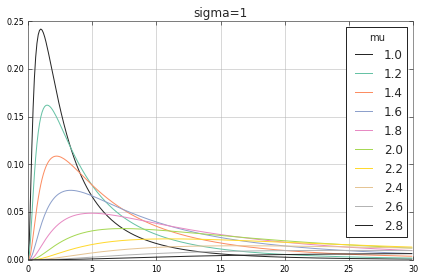

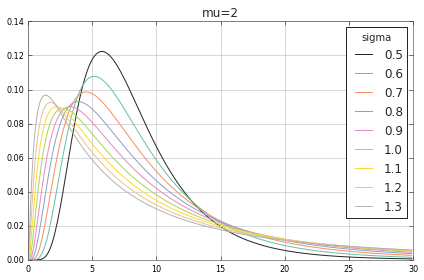

In [11]:
x=np.arange(0,30,0.1)
for m in np.arange(1,5,0.4):
    plt.plot(x,stats.lognorm.pdf(x,1,loc=0,scale=np.exp(m)))
plt.legend(np.arange(1,5,0.2),title='mu')
plt.title('sigma=1');
plt.figure()
for m in  np.arange(0.5,1.4,0.1):
    plt.plot(x,stats.lognorm.pdf(x,m,loc=0,scale=np.exp(2)))
plt.legend(np.arange(0.5,1.4,0.1),title='sigma')
plt.title('mu=2');

Note that $\mu$ is not the mean of the lognormal distribution. $\mu$ shifts the mode of the distribution but it also contributes to the width of the distribution.

#### Coming Next

Next time I will show how the distributions look on the log-scale. This will provide more diagnostic view of the various distributions.